# Next Day temperature prediction using Open-Meteo Historical Weather API

Our goal here is to predict the maximum temperature of the next day based on the historical daily weather data from Open-Meteo. 

For this we will be using the regression techniques - Linear, Ridge, Lasso, Random Forest, XGBoost on our weather features engineerd from openmeteo data

In [1]:
import requests
import datetime
import pandas as pd
from datetime import date, timedelta # to set forecast number of days if needed
import numpy as np

## OPENMETEO API CALL REQUEST TO GET THE HISTORICAL DATA

In [3]:
latitude = 13.0845
longitude = 87.2705
START = "2015-01-01" #considering past 10 years of data 
#END = "2025-10-29"
END = date.today().strftime("%Y-%m-%d")
DAILY_VARIABLES = "weather_code,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,wind_speed_10m_max"
#DAILY_VARIABLES based on the availability as per the API documentation
TIMEZONE = "Asia/Kolkata"
#refer https://en.wikipedia.org/wiki/List_of_tz_database_time_zones



In [4]:
def get_open_meteo_data(latitude, longitude, start_date, end_date, vars, timezone):
    url = "https://archive-api.open-meteo.com/v1/archive"
    archive_params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date" : end_date,
        "daily" : vars,
        "timezone": timezone
    }
    response = requests.get(url, params = archive_params)
    response.raise_for_status()
    historical_data = response.json()
    daily_data = pd.DataFrame(historical_data["daily"])
    daily_data["time"] = pd.to_datetime(daily_data["time"])
    daily_data = daily_data.rename(columns= {"time" : "date",
                                             "weather_code" : "weather",
                                             "temperature_2m_max" : "temp_max",
                                             "temperature_2m_min" : "temp_min",
                                             "precipitation_sum" : "rainfall",
                                             "rain_sum" : "sum_of_daily_rain",
                                             "wind_speed_10m_max" : "wind_speed"})
                                             
    return daily_data
    

In [5]:
daily_weather_df = get_open_meteo_data(latitude, longitude, START, END, DAILY_VARIABLES, TIMEZONE)

In [6]:
daily_weather_df.shape

(3957, 7)

In [7]:
daily_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               3957 non-null   datetime64[ns]
 1   weather            3957 non-null   int64         
 2   temp_max           3957 non-null   float64       
 3   temp_min           3957 non-null   float64       
 4   rainfall           3957 non-null   float64       
 5   sum_of_daily_rain  3957 non-null   float64       
 6   wind_speed         3957 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 216.5 KB


In [8]:
print(daily_weather_df['date'].min(), daily_weather_df['date'].max())

2015-01-01 00:00:00 2025-10-31 00:00:00


## FEATURE ENGINEERING

In [9]:
def feature_engineering(df):
    df = df.copy()# so that it will not disturb the original df
    df["day_of_year"] = df["date"].dt.dayofyear
    df["month"] = df["date"].dt.month
    df["weekday"] = df["date"].dt.weekday
    #cyclical encoding
    df["day_sin"] = np.sin(2* np.pi*df["day_of_year"]/365)
    df["day_cos"] = np.cos(2 * np.pi*df["day_of_year"]/365)
    #lag
    for lag in [1,2,3,7,14]:
        df[f"temp_max_lag_{lag}"] = df["temp_max"].shift(lag)
    '''
    looping through multiple lag periods like 1 day lag 3 day lag. 
    this will give us 5 new lag columns.
    .shift moves down by n rows.(days)
    lag_1 - yesterday's temp lag_7 - a week ago temp.
    If too many lags, this might prone to overfitting due to high dimensionality
    '''
    #rolling averages
    df["rolling_avg7_temp"] = df["temp_max"].shift(1).rolling(7).mean()
    '''
    7 day moving average temperature of past temperatures.
    '''
    #target
    df["temp_max_next_day"] = df["temp_max"].shift(-1)
    '''
    shift(1) 1 day before
    shift(-1) 1 day after
    '''
    return df.dropna().reset_index(drop=True)
    

In [10]:
featured_df = feature_engineering(daily_weather_df)
print(featured_df.shape)

(3942, 19)


In [11]:
featured_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3942 entries, 0 to 3941
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               3942 non-null   datetime64[ns]
 1   weather            3942 non-null   int64         
 2   temp_max           3942 non-null   float64       
 3   temp_min           3942 non-null   float64       
 4   rainfall           3942 non-null   float64       
 5   sum_of_daily_rain  3942 non-null   float64       
 6   wind_speed         3942 non-null   float64       
 7   day_of_year        3942 non-null   int32         
 8   month              3942 non-null   int32         
 9   weekday            3942 non-null   int32         
 10  day_sin            3942 non-null   float64       
 11  day_cos            3942 non-null   float64       
 12  temp_max_lag_1     3942 non-null   float64       
 13  temp_max_lag_2     3942 non-null   float64       
 14  temp_max

## Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
#target column is the temp_max_next_day
x = featured_df.drop(columns = ["temp_max_next_day"])
y = featured_df["temp_max_next_day"]
print(x.shape)
print(y.shape)

(3942, 18)
(3942,)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    shuffle=False)

print(f"Train {x_train.shape}, \n Test {x_test.shape}")

Train (3153, 18), 
 Test (789, 18)


###  Train test split visualization (Time series viz with days and year)
1. IN TERMS OF DAYS (total records)
2. IN TERMS OF DATE (year based)

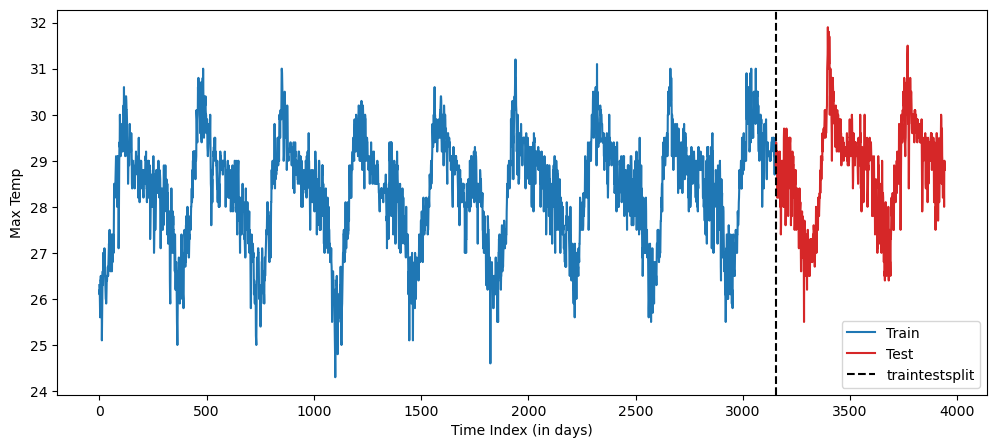

In [26]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
#by taking the y_train.index we are taking the row index
#as we have already split train and test, we can clearly see the data split in numbers
plt.plot(y_train.index, y_train, label = "Train", color='tab:blue')
plt.plot(y_test.index, y_test, label = "Test", color='tab:red')
#a line to seperate where the test starts.
split_index = len(y_train)
plt.axvline(x= split_index, color ='black', linestyle='--', label="traintestsplit")

plt.xlabel("Time Index (in days)")
plt.ylabel("Max Temp")
plt.legend()
plt.show()

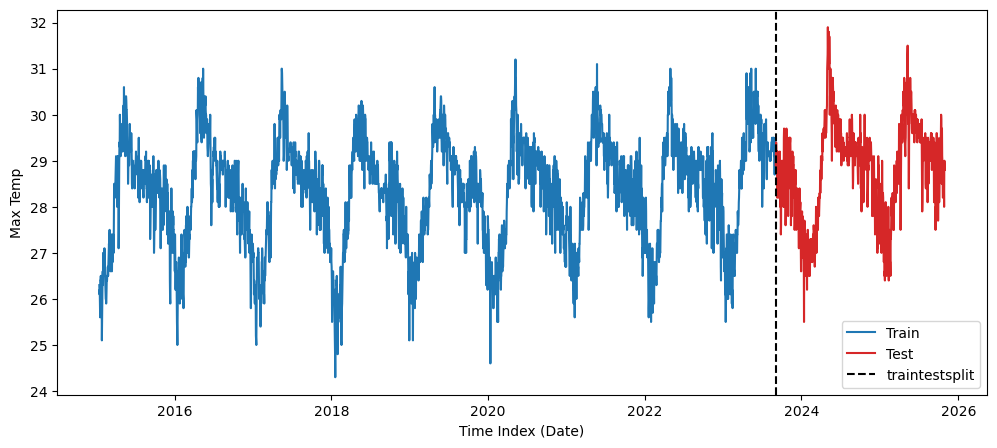

In [27]:
plt.figure(figsize=(12, 5))
#considerin the date field till the training data length
plt.plot(featured_df['date'][:len(y_train)], y_train, label="Train", color='tab:blue')
plt.plot(featured_df['date'][len(y_train):], y_test, label="Test", color='tab:red')
plt.axvline(featured_df['date'].iloc[len(y_train)], color='black', linestyle='--', label='traintestsplit')
plt.xlabel("Time Index (Date)")
plt.ylabel("Max Temp")
plt.legend()
plt.show()

In [28]:
featured_df.columns

Index(['date', 'weather', 'temp_max', 'temp_min', 'rainfall',
       'sum_of_daily_rain', 'wind_speed', 'day_of_year', 'month', 'weekday',
       'day_sin', 'day_cos', 'temp_max_lag_1', 'temp_max_lag_2',
       'temp_max_lag_3', 'temp_max_lag_7', 'temp_max_lag_14',
       'rolling_avg7_temp', 'temp_max_next_day'],
      dtype='object')

In [29]:
featured_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3942 entries, 0 to 3941
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               3942 non-null   datetime64[ns]
 1   weather            3942 non-null   int64         
 2   temp_max           3942 non-null   float64       
 3   temp_min           3942 non-null   float64       
 4   rainfall           3942 non-null   float64       
 5   sum_of_daily_rain  3942 non-null   float64       
 6   wind_speed         3942 non-null   float64       
 7   day_of_year        3942 non-null   int32         
 8   month              3942 non-null   int32         
 9   weekday            3942 non-null   int32         
 10  day_sin            3942 non-null   float64       
 11  day_cos            3942 non-null   float64       
 12  temp_max_lag_1     3942 non-null   float64       
 13  temp_max_lag_2     3942 non-null   float64       
 14  temp_max

## DATA STANDARDIZATION

In [30]:
#data standardization - so that mean 0 and standard deviation 1 - zscore normalization
'''our features have different magnitudes like rainfall in mm/cm, temp id deg cel,
wind speed like 1, 10
if not scaled, these features with large ranges can dominate the model. With scaling all 
features contribute fairly
we didnt try this iwth MinMaxScaler or RobustScaler because, weather kind of data mostly
it is normal kind of distribution so StandardScaler.
MinMaxScaler - for bounded data [0,1]
RobustScaler - data with extreme values
'''
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler

StandardScaler()

## JUST FOR UNDERSTANDING PURPOSE ONLY. 

In [19]:
#fit and transform with train and just transform with test
#THE ERROR IS INTENTIONAL. CHECK THE NEXT CODE.
train_scaled = scaler.fit_transform(x_train)
test_scaled = scaler.transform(x_test)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [23]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3153 entries, 0 to 3152
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               3153 non-null   datetime64[ns]
 1   weather            3153 non-null   int64         
 2   temp_max           3153 non-null   float64       
 3   temp_min           3153 non-null   float64       
 4   rainfall           3153 non-null   float64       
 5   sum_of_daily_rain  3153 non-null   float64       
 6   wind_speed         3153 non-null   float64       
 7   day_of_year        3153 non-null   int32         
 8   month              3153 non-null   int32         
 9   weekday            3153 non-null   int32         
 10  day_sin            3153 non-null   float64       
 11  day_cos            3153 non-null   float64       
 12  temp_max_lag_1     3153 non-null   float64       
 13  temp_max_lag_2     3153 non-null   float64       
 14  temp_max_lag_

In [24]:
x_train.drop(columns=['date'], inplace=True)
x_test.drop(columns=['date'],inplace=True)

###  MODELS
1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. Random Forest
5. XGBoost

### SAVING TRAIN and TEST DATA UNSCALED, and SCALER 

In [31]:
#Saving the preprocessed data
import joblib
import os
current_directory = os.getcwd()
print(current_directory)#if needed, we can use current_directory to save

C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\notebooks


In [33]:
print(x_train.shape,
      x_test.shape,
      y_train.shape,
      y_test.shape)
      

(3153, 18) (789, 18) (3153,) (789,)


In [34]:
pd.DataFrame(x_train, columns=x_train.columns).to_csv(r"C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\data\x_train.csv", index=False)
pd.DataFrame(x_test, columns = x_test.columns).to_csv(r"C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\data\x_test.csv", index=False)
y_train.to_csv(r"C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\data\y_train.csv", index=False)
y_test.to_csv(r"C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\data\y_test.csv", index=False)

In [35]:
#joblib.dump(modelname/var , path)
joblib.dump(scaler, r"C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\models\scaler.pkl")

['C:\\Users\\elakkiya\\json_tutorial\\Chennai_Weather_Prediction\\models\\scaler.pkl']

## this will be loaded and reused in the respective model notebooks